### Creating readability scores

To compute readability, we will calculate the average sentence length and average word length


**Note: Due to file size issues, we are only computing readability for a small selection of the total sample**

In [1]:
import pandas as pd
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize, sent_tokenize

# Load the data from the CSV file
data = pd.read_csv("reduced_chapter_text.csv")

# Function to calculate average word length
def avg_word_length(text):
    words = word_tokenize(text)
    word_lengths = [len(word) for word in words]
    return sum(word_lengths) / len(word_lengths) if len(word_lengths) > 0 else 0

# Function to calculate average sentence length
def avg_sentence_length(text):
    sentences = sent_tokenize(text)
    sentence_lengths = [len(sent.split()) for sent in sentences]
    return sum(sentence_lengths) / len(sentence_lengths) if len(sentence_lengths) > 0 else 0

# Calculate average word length and average sentence length for each storyId
averages = data.groupby('storyId').apply(lambda x: pd.Series({
    'avg_word_length': x['text'].apply(avg_word_length).mean(),
    'avg_sentence_length': x['text'].apply(avg_sentence_length).mean()
}))

# Store averages for later use
averages.to_csv("story_averages.csv")

print("Average word and sentence lengths calculated and stored successfully.")


# Calculate average word length and average sentence length for storyId 63, to check functionality
averages = data[data['storyId'] == 63]
avg_word_length_63 = averages['text'].apply(avg_word_length).mean()
avg_sentence_length_63 = averages['text'].apply(avg_sentence_length).mean()

# Print the results of test
print("Average word length for storyId 63:", avg_word_length_63)
print("Average sentence length for storyId 63:", avg_sentence_length_63)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\readi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Average word and sentence lengths calculated and stored successfully.
Average word length for storyId 63: 3.6958509142053444
Average sentence length for storyId 63: 12.740112994350282


### Finding correlation between readability and popularity

Here, we compute the correlation between our two notions of readability and our four notions of popularity.

In [2]:
# Load the stored averages
averages = pd.read_csv("story_averages.csv")

# Load the popularity metrics
popularity_metrics = pd.read_csv("reduced_project_info.csv")

# Merge the averages and popularity metrics on storyId
merged_data = pd.merge(popularity_metrics, averages, left_on='id', right_on='storyId')

# Calculate correlations
correlations = merged_data[['avg_word_length', 'avg_sentence_length', 'hits', 'kudos', 'comments', 'bookmarks']].corr()

print("Correlation between Average Word Length, Average Sentence Length, and Popularity Metrics:")
print(correlations)

# Define a function to interpret correlation values
def interpret_correlation(correlation):
    if correlation > 0.7:
        return "Strong positive correlation"
    elif correlation > 0.3:
        return "Moderate positive correlation"
    elif correlation > -0.3:
        return "Weak or no correlation"
    elif correlation > -0.7:
        return "Moderate negative correlation"
    else:
        return "Strong negative correlation"

# Iterate over each pair of variables in the correlation matrix and interpret the correlation
for column1 in correlations.columns:
    for column2 in correlations.columns:
        if column1 != column2:
            correlation = correlations.loc[column1, column2]
            interpretation = interpret_correlation(correlation)
            print(f"\nCorrelation between {column1} and {column2}: {interpretation}")


Correlation between Average Word Length, Average Sentence Length, and Popularity Metrics:
                     avg_word_length  avg_sentence_length      hits     kudos  \
avg_word_length             1.000000             0.178947  0.007897  0.004962   
avg_sentence_length         0.178947             1.000000  0.013776  0.009300   
hits                        0.007897             0.013776  1.000000  0.935438   
kudos                       0.004962             0.009300  0.935438  1.000000   
comments                   -0.002383             0.005629  0.818407  0.749074   
bookmarks                   0.008979             0.009061  0.926273  0.943758   

                     comments  bookmarks  
avg_word_length     -0.002383   0.008979  
avg_sentence_length  0.005629   0.009061  
hits                 0.818407   0.926273  
kudos                0.749074   0.943758  
comments             1.000000   0.844439  
bookmarks            0.844439   1.000000  

Correlation between avg_word_length and 

### Result: Readability does not predict popularity

There is a weak or no correlation between our measures of readability and our measures of popularity, indicating that popularity can not be predicted by readability. Somewhat surprisingly, there is also no strong correlation between our two measures of readability however, there is a strong positive correlation between the different notions of popularity. 

### Finding the most and least readable works

Here we find and print the ID numbers for the work with the longest average sentence length, the shortest average sentence length, the longest average word length, and the shortest average word length.

In [3]:
# Load the stored averages
averages = pd.read_csv("story_averages.csv")

# Find the work with the maximum and minimum average word length
max_avg_word_length = averages.loc[averages['avg_word_length'].idxmax()]
min_avg_word_length = averages.loc[averages['avg_word_length'].idxmin()]

# Find the work with the maximum and minimum average sentence length
max_avg_sentence_length = averages.loc[averages['avg_sentence_length'].idxmax()]
min_avg_sentence_length = averages.loc[averages['avg_sentence_length'].idxmin()]

print("Work with Maximum Average Word Length:")
print(max_avg_word_length)

print("\nWork with Minimum Average Word Length:")
print(min_avg_word_length)

print("\nWork with Maximum Average Sentence Length:")
print(max_avg_sentence_length)

print("\nWork with Minimum Average Sentence Length:")
print(min_avg_sentence_length)


Work with Maximum Average Word Length:
storyId                103753.000000
avg_word_length             5.356742
avg_sentence_length        11.072289
Name: 4144, dtype: float64

Work with Minimum Average Word Length:
storyId                82910.000000
avg_word_length            2.720848
avg_sentence_length        8.631579
Name: 3374, dtype: float64

Work with Maximum Average Sentence Length:
storyId                32287.000000
avg_word_length            3.894379
avg_sentence_length      741.500000
Name: 1293, dtype: float64

Work with Minimum Average Sentence Length:
storyId                41540.000000
avg_word_length            3.281768
avg_sentence_length        4.100000
Name: 1671, dtype: float64


## Tag Analysis

### Tag analysis with NLP
Project contains analysis of AO3 tags using NLP

In [2]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.metrics import accuracy_score
import nltk

data_tags = pd.read_csv('small_story_tags.csv')
data_tags

Unnamed: 0  storyId  tagId                       Tag Name      Tag Type
0              0        3      1      No Archive Warnings Apply       warning
1              1        3      2                          Other      category
2              2        3      3  Viggo Mortensen/Orlando Bloom  relationship
3              3        3      4          Lord of the Rings RPF        fandom
4              4        3      5                      Sean Bean     character
...          ...      ...    ...                            ...           ...
4189        4189    11615   1891                   Brendon Urie     character
4190        4190    11615   1892                      Ryan Ross     character
4191        4191    11615   1893                     Jon Walker     character
4192        4192    11615   1894                      Zack Hall     character
4193        4193    11615    187                     First Time       generic

[4194 rows x 5 columns]

In [3]:
print(data_tags['Tag Type'].unique(),',',data_tags['Tag Type'].nunique())
print()
print(data_tags['Tag Name'].unique(),',',data_tags['Tag Name'].nunique())


['warning' 'category' 'relationship' 'fandom' 'character' 'generic'] , 6

['No Archive Warnings Apply' 'Other' 'Viggo Mortensen/Orlando Bloom' ...
 'Ryan Ross' 'Jon Walker' 'Zack Hall'] , 1892


In [4]:
tag_names = data_tags['Tag Name'].to_list()
tag_names = [str(tag) for tag in tag_names]
tag_names_str = ' '.join(tag_names)

CountV = CountVectorizer()
CountV_tag_names = CountV.fit_transform(tag_names)

X_train, X_test, y_train, y_test = train_test_split(CountV_tag_names, data_tags['Tag Type'], train_size=0.8)

tags_classifier = MultinomialNB()
tags_classifier.fit(X_train,y_train)
tags_pred = tags_classifier.predict(X_test)
print('Confusion Matrix:')
print(metrics.confusion_matrix(y_true = y_test, y_pred = tags_pred))
print(accuracy_score(y_test, tags_pred))


Confusion Matrix:
[[ 40   0   0  58   0   0]
 [ 18 124   8  21  35   0]
 [  2   7  80  10   0   0]
 [  6   2   7 249   0   1]
 [  3  67   0   1   9   1]
 [  0   0   0   0   0  90]]
0.7056019070321812


### Result: 
- The natural language learning model is able to predict the correct tag type based on the tag name with about 70% accuracy. Often, it would confuse "category" tags with "character" tags or "fandoms" with "warnings".

### Extra Tag Analysis Code

The code provided below was used in the tag analysis, and was not included in our final results to reduce the length of code the reader would have to sort through. 


/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

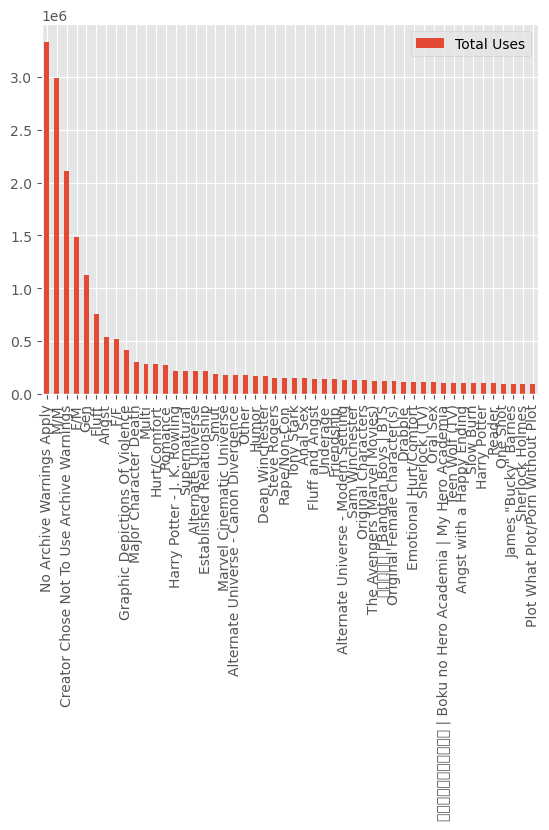

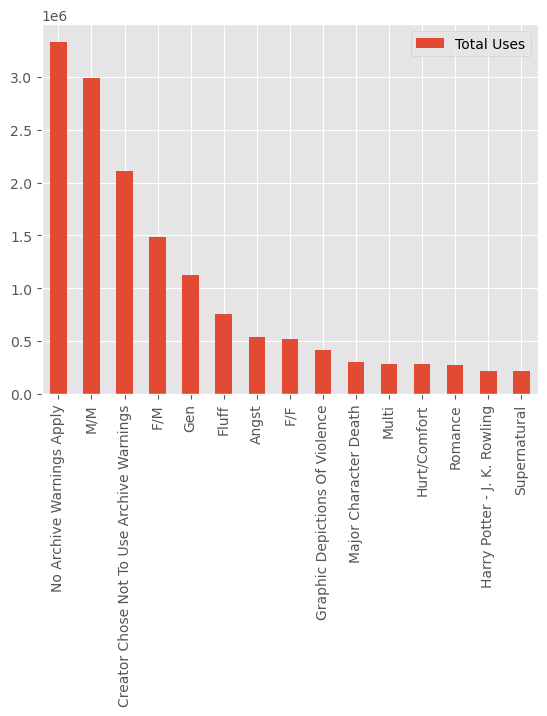

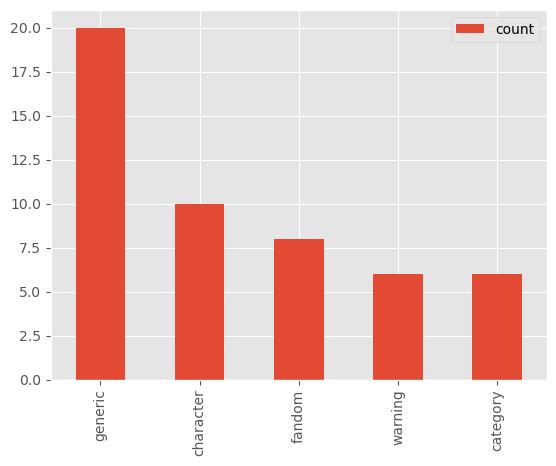

In [6]:
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

# Top Tags looks at tags that have been used at least 5000 times.
top_tags = pd.read_csv("top_tags.csv")
tag_usage = pd.read_csv('top_tags_names.csv')

# Graphing our Series

top_50 = tag_usage[:50]
top_10 = tag_usage[:15]

#plt.bar(top_50["tagId"].tolist(), top_50["Total Uses"].tolist())
def plot_name(df):
    df.plot(kind="bar",
               y = "Total Uses")
    plt.xticks(df.index.to_list(), df["Tag Name"].tolist())
    plt.show()

plot_name(top_50)
plot_name(top_10)

# Top 50 Tag Type

tag_type = top_50["Tag Type"].value_counts().to_frame().reset_index()
tag_type.plot(kind = "bar")

plt.xticks(tag_type.index.to_list(), tag_type["Tag Type"].tolist())
plt.show()

We see that in the top 50 tags, there are no actual relationship tags. This was actually quite surprising to me, as there are many well known fandom pairings. We also can find that the most common tags labeled in our generic category appear to be genres. So despite AO3 not having specific genre tags, they are among the most used tags. 

We also see that from the start of the site until July 2020, the top fifteen most popular fandoms are as follows.

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

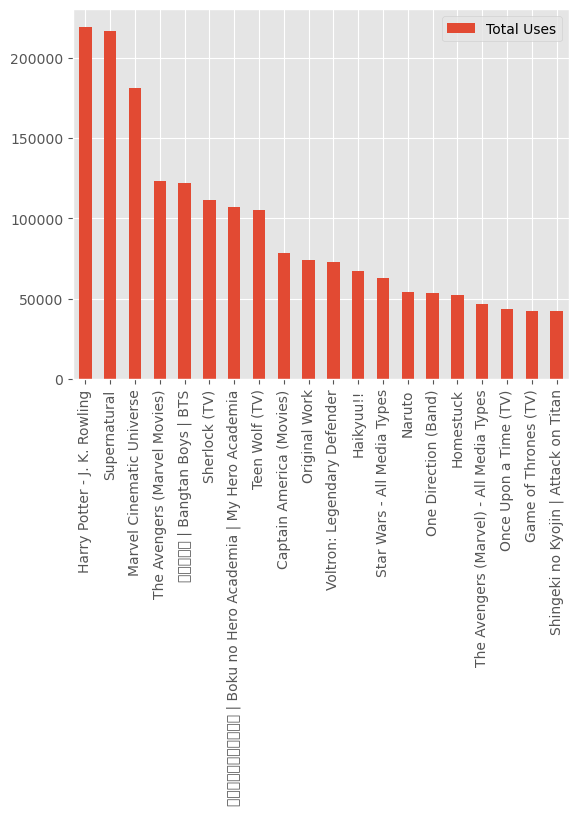

In [7]:
fandoms = tag_usage.copy(deep=True)
fandoms = fandoms[fandoms["Tag Type"] == "fandom"].reset_index()
fan_10 = fandoms[:20]

fan_10.plot(kind="bar",
           y = "Total Uses")
plt.xticks(fan_10.index.to_list(), fan_10["Tag Name"].tolist())
plt.show()

We see that in the ten most popular fandoms, eight involve fictional universes and characters. However, the fifth most popular fandom is BTS, a real k-pop group. This shows us there are a significant amount of works that include real life celebrities as characters, rather than just fictional individuals.

Though it barely made it in the top 10, we also see that Original Works are very common. An original work is just as it sounds, a piece not based on any fictional or real group, and instead centers an author's unique story. This is very interesting since fanfiction sites are seen as full of works that are not publishable due to copyright. However, many works tag themselves with their own universe. 


We now focus on the most popular tags within each fandom. Are there similarities; differences?

    tagId  Total Uses                                   Tag Name      Tag Type
0    1934      219313               Harry Potter - J. K. Rowling        fandom
1       1      118918                  No Archive Warnings Apply       warning
2      17      101286                                        M/M      category
3    1660       96380                               Harry Potter     character
4       9       75698  Creator Chose Not To Use Archive Warnings       warning
5      44       71318                                        F/M      category
6     336       59973                               Draco Malfoy     character
7     500       59578                           Hermione Granger     character
8      38       42609                                        Gen      category
9    2684       40311                                Ron Weasley     character
10     99       36749                              Severus Snape     character
11    335       35362                  Draco Malfoy/

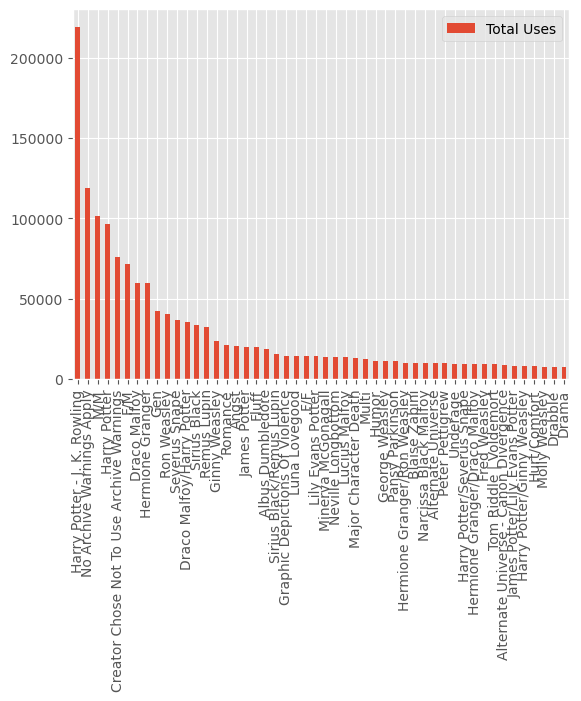

    tagId  Total Uses                                   Tag Name      Tag Type
0      90      216811                               Supernatural        fandom
1      92      164770                            Dean Winchester     character
2      17      132312                                        M/M      category
3      96      132053                             Sam Winchester     character
4       1      121387                  No Archive Warnings Apply       warning
5    5037       78331                    Castiel/Dean Winchester  relationship
6     878       77089                                    Castiel     character
7       9       73472  Creator Chose Not To Use Archive Warnings       warning
8      38       46007                                        Gen      category
9      44       38961                                        F/M      category
10  41188       34842                     Castiel (Supernatural)     character
11    121       31357                               

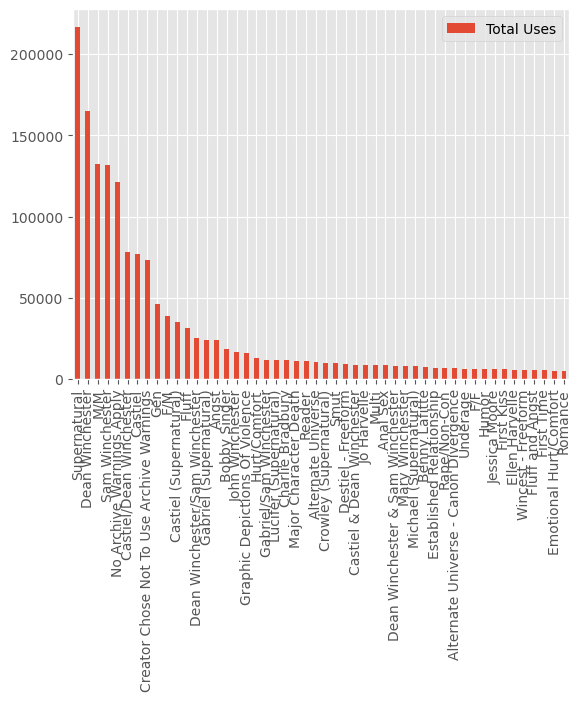

     tagId  Total Uses                                   Tag Name  \
0     8020      181007                  Marvel Cinematic Universe   
1        1      110077                  No Archive Warnings Apply   
2     1462       83342                               Steve Rogers   
3     1461       82797                                 Tony Stark   
4       17       81758                                        M/M   
5    26269       73693               The Avengers (Marvel Movies)   
6    19379       59906                       James "Bucky" Barnes   
7       44       57084                                        F/M   
8        9       55242  Creator Chose Not To Use Archive Warnings   
9    19377       45896                   Captain America (Movies)   
10   10291       42165                               Clint Barton   
11      38       41686                                        Gen   
12    2304       32566                               Peter Parker   
13     121       29378            

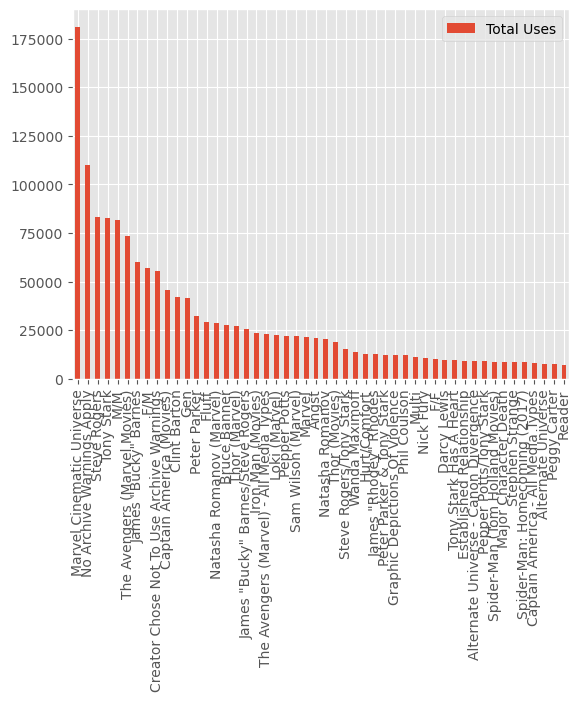

     tagId  Total Uses                                   Tag Name  \
0    26269      123369               The Avengers (Marvel Movies)   
1     8020       73693                  Marvel Cinematic Universe   
2     1461       71758                                 Tony Stark   
3        1       69462                  No Archive Warnings Apply   
4     1462       65155                               Steve Rogers   
5       17       56289                                        M/M   
6    10291       43142                               Clint Barton   
7        9       42746  Creator Chose Not To Use Archive Warnings   
8       44       40564                                        F/M   
9    19379       37017                       James "Bucky" Barnes   
10   19377       31771                   Captain America (Movies)   
11   22537       29786                               Bruce Banner   
12      38       28398                                        Gen   
13   17237       25977            

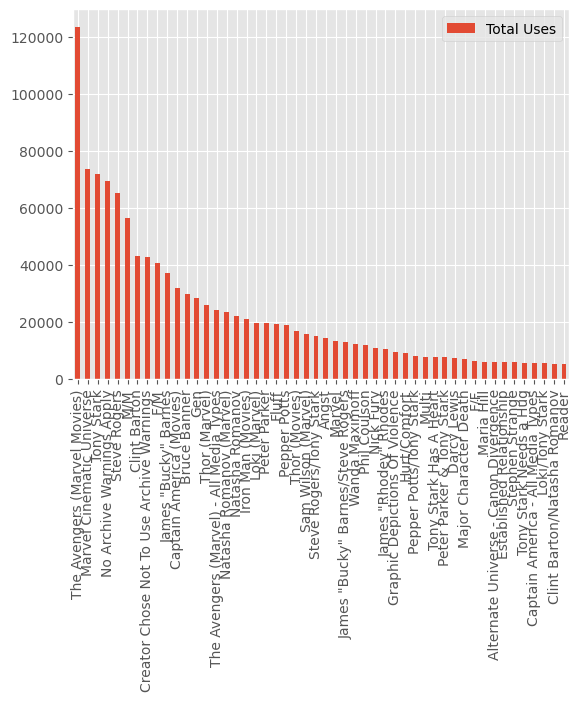

     tagId  Total Uses                                     Tag Name  \
0    74900      122268                   방탄소년단 | Bangtan Boys | BTS   
1       17       99705                                          M/M   
2   154631       76845                                Jeon Jungkook   
3    85876       75243                            Min Yoongi | Suga   
4   135573       74834                             Park Jimin (BTS)   
5   115548       72207                             Kim Taehyung | V   
6   110855       60155                         Jung Hoseok | J-Hope   
7   115547       59603                            Kim Seokjin | Jin   
8        1       59602                    No Archive Warnings Apply   
9        9       52245    Creator Chose Not To Use Archive Warnings   
10  303406       43786                             Kim Namjoon | RM   
11     121       34069                                        Fluff   
12  156599       21747               Jeon Jungkook/Kim Taehyung | V   
13    

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

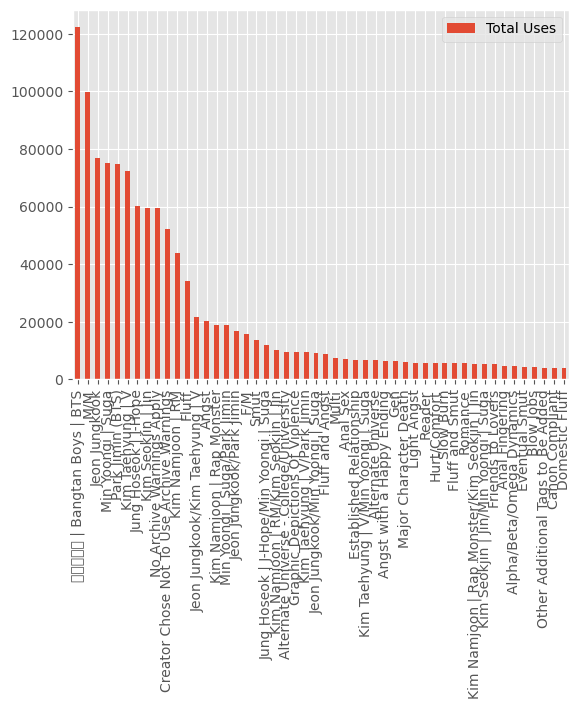

    tagId  Total Uses                                   Tag Name      Tag Type
0   10216      111159                              Sherlock (TV)        fandom
1     447       85944                            Sherlock Holmes     character
2     450       73977                                John Watson     character
3      17       68962                                        M/M      category
4       1       60904                  No Archive Warnings Apply       warning
5    3253       53086                Sherlock Holmes/John Watson  relationship
6       9       45062  Creator Chose Not To Use Archive Warnings       warning
7    9741       33055                             Mycroft Holmes     character
8   26047       27042                              Greg Lestrade     character
9   10373       25221          Sherlock Holmes & Related Fandoms        fandom
10     38       24314                                        Gen      category
11     44       19042                               

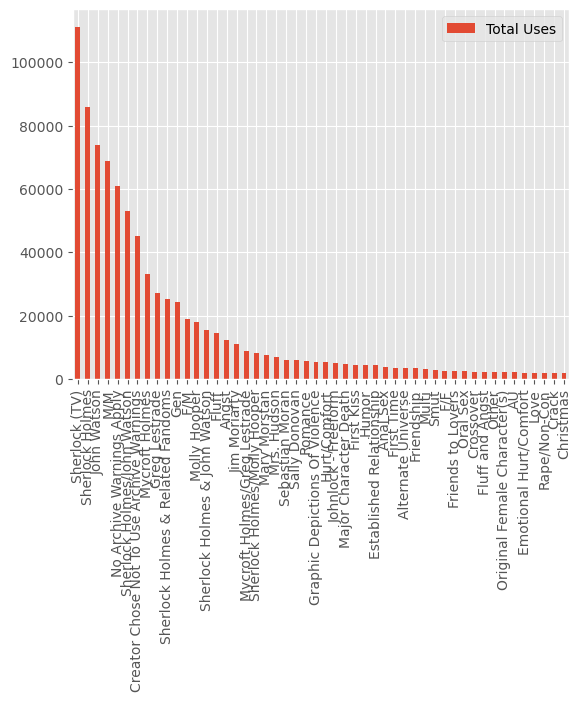

     tagId  Total Uses                                           Tag Name  \
0   151456      107203  僕のヒーローアカデミア | Boku no Hero Academia | My Hero ...   
1       17       62135                                                M/M   
2   152678       55648                                     Midoriya Izuku   
3        1       54097                          No Archive Warnings Apply   
4   151458       53547                                    Bakugou Katsuki   
5        9       38257          Creator Chose Not To Use Archive Warnings   
6   152679       34182                                    Todoroki Shouto   
7   151457       30395                                  Kirishima Eijirou   
8   233209       25705                         Aizawa Shouta | Eraserhead   
9       44       25438                                                F/M   
10  226093       23417                                     Uraraka Ochako   
11  214843       20098                                     Kaminari Denki   

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20693 (\N{CJK UNIFIED IDEOGRAPH-50D5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12525 (\N{KATAKANA LETTER R

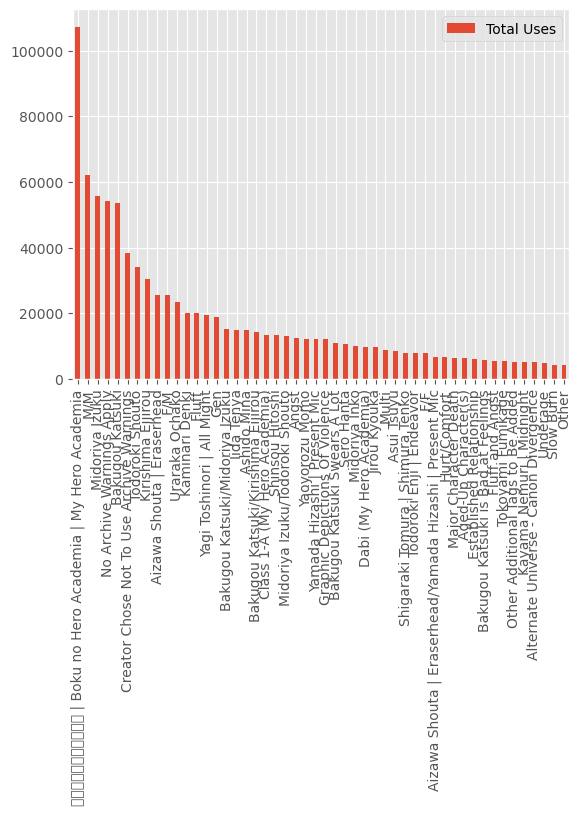

     tagId  Total Uses                                   Tag Name  \
0    20845      105087                             Teen Wolf (TV)   
1    20991       79208                           Stiles Stilinski   
2       17       77280                                        M/M   
3    20847       64877                                 Derek Hale   
4    20952       56073                Derek Hale/Stiles Stilinski   
5        1       53263                  No Archive Warnings Apply   
6        9       40267  Creator Chose Not To Use Archive Warnings   
7    20999       30415                               Scott McCall   
8    20994       28829                               Lydia Martin   
9    31421       22130                                Isaac Lahey   
10   20995       20733                          Sheriff Stilinski   
11      44       20557                                        F/M   
12   20992       19627                             Allison Argent   
13   21690       18469            

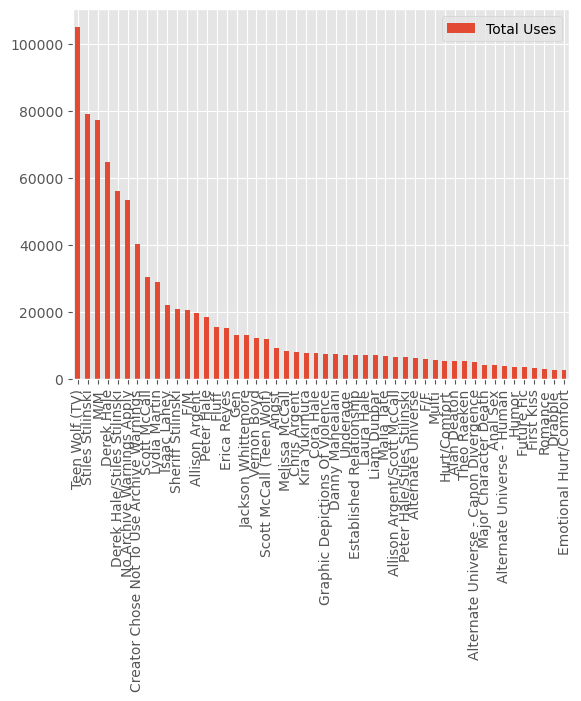

     tagId  Total Uses                                   Tag Name  \
0    19377       78689                   Captain America (Movies)   
1     1462       62671                               Steve Rogers   
2    19379       54311                       James "Bucky" Barnes   
3       17       48012                                        M/M   
4        1       46246                  No Archive Warnings Apply   
5     8020       45896                  Marvel Cinematic Universe   
6    19891       34105          James "Bucky" Barnes/Steve Rogers   
7    26269       31771               The Avengers (Marvel Movies)   
8        9       26097  Creator Chose Not To Use Archive Warnings   
9     1461       24840                                 Tony Stark   
10      44       21696                                        F/M   
11   31567       17318                        Sam Wilson (Marvel)   
12   10291       16096                               Clint Barton   
13      38       13579            

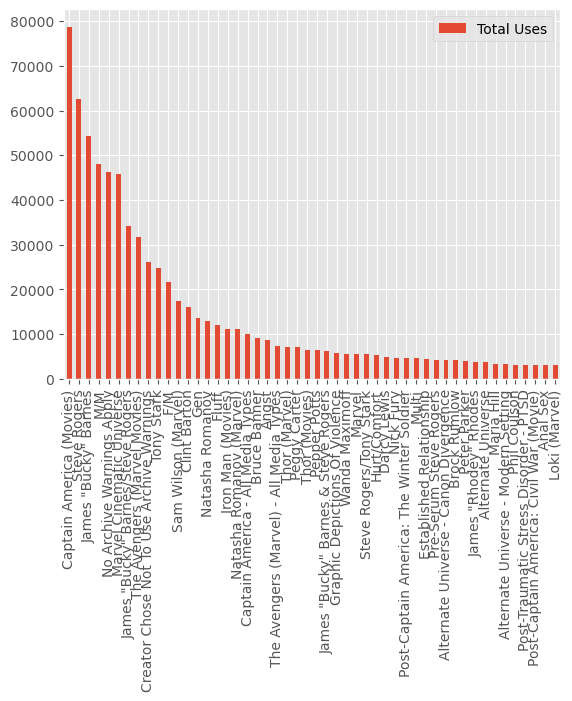

    tagId  Total Uses                                           Tag Name  \
0    2918       74383                                      Original Work   
1       1       33441                          No Archive Warnings Apply   
2       9       26835          Creator Chose Not To Use Archive Warnings   
3      17       20452                                                M/M   
4      38       18338                                                Gen   
5      44       16961                                                F/M   
6     476       12140                                Original Characters   
7     413       10079                     Graphic Depictions Of Violence   
8     105        9846                                                F/F   
9   18152        9059                         Original Male Character(s)   
10  18151        8567                       Original Female Character(s)   
11      2        7512                                              Other   
12    213   

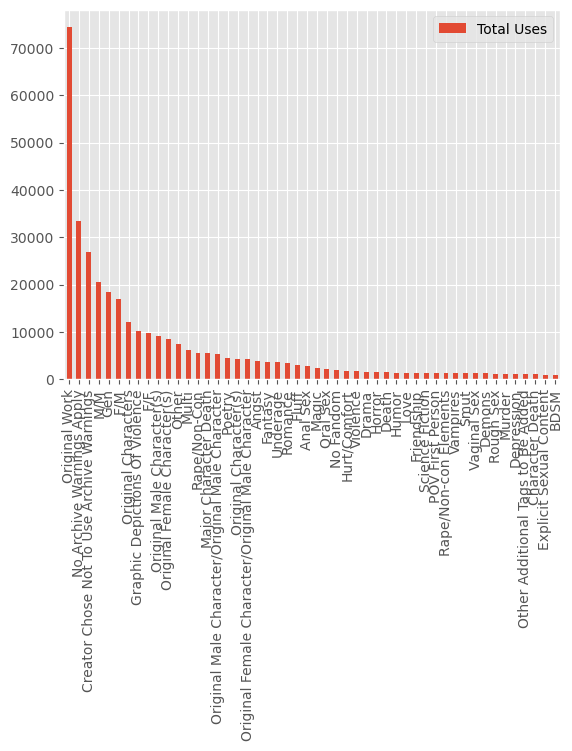

     tagId  Total Uses                                   Tag Name  \
0   230901       73103                Voltron: Legendary Defender   
1    19464       54267                            Keith (Voltron)   
2       17       51218                                        M/M   
3    19465       48038                            Lance (Voltron)   
4   230902       44678                            Shiro (Voltron)   
5        1       43831                  No Archive Warnings Apply   
6    19678       30203                             Hunk (Voltron)   
7    19463       28395                      Keith/Lance (Voltron)   
8    88783       26375                           Allura (Voltron)   
9   235588       25484                         Pidge | Katie Holt   
10       9       22936  Creator Chose Not To Use Archive Warnings   
11  229883       16692                            Coran (Voltron)   
12     121       13720                                      Fluff   
13  234286       13281            

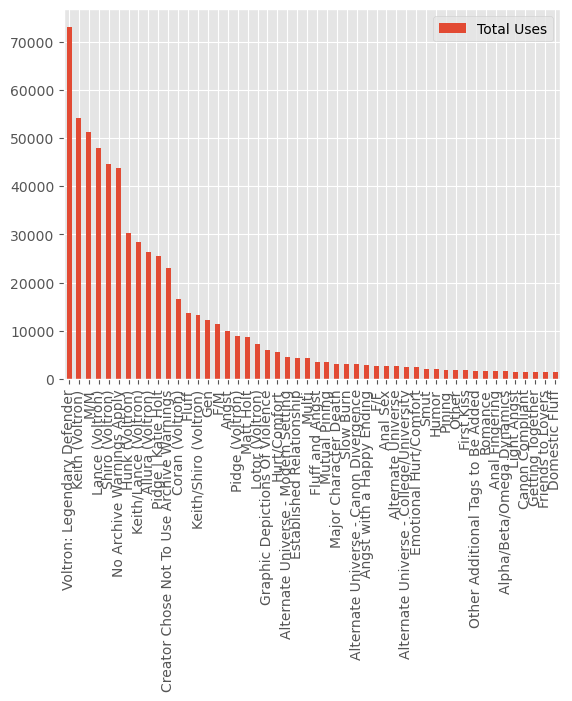

     tagId  Total Uses                                   Tag Name  \
0    61610       67036                                  Haikyuu!!   
1       17       55770                                        M/M   
2        1       42194                  No Archive Warnings Apply   
3        9       21647  Creator Chose Not To Use Archive Warnings   
4   106245       18594                               Oikawa Tooru   
5    75695       18390                             Hinata Shouyou   
6    97742       18216                             Kuroo Tetsurou   
7    75696       16847                             Kageyama Tobio   
8      121       16173                                      Fluff   
9   107348       14343                            Iwaizumi Hajime   
10   98966       14026                             Tsukishima Kei   
11   98483       12891                            Bokuto Koutarou   
12   61612       12610                            Sugawara Koushi   
13   61611       12013            

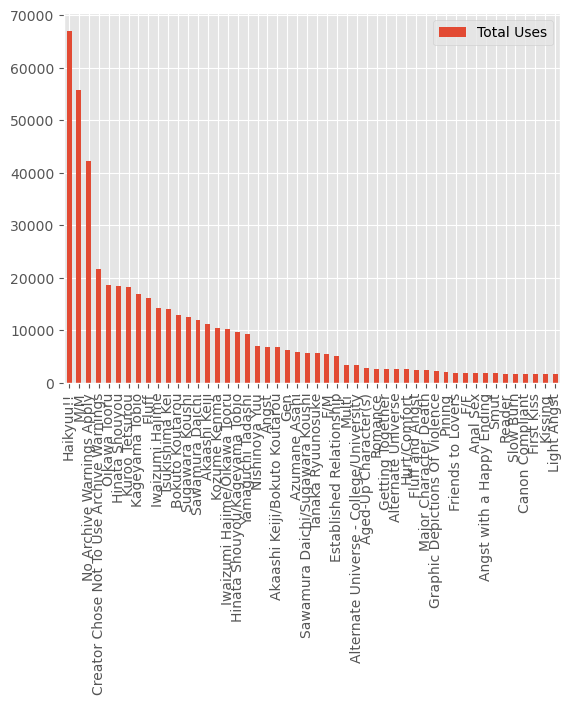

     tagId  Total Uses                                           Tag Name  \
0     1525       62806                        Star Wars - All Media Types   
1        1       36316                          No Archive Warnings Apply   
2       44       29217                                                F/M   
3        9       19119          Creator Chose Not To Use Archive Warnings   
4   187582       18595                           Star Wars Sequel Trilogy   
5       17       18450                                                M/M   
6   165136       18013                                    Rey (Star Wars)   
7   187903       15550                                Ben Solo | Kylo Ren   
8       38       15405                                                Gen   
9     2785       12878                                        Leia Organa   
10  187176       11783                                        Poe Dameron   
11     285       11505                                     Obi-Wan Kenobi   

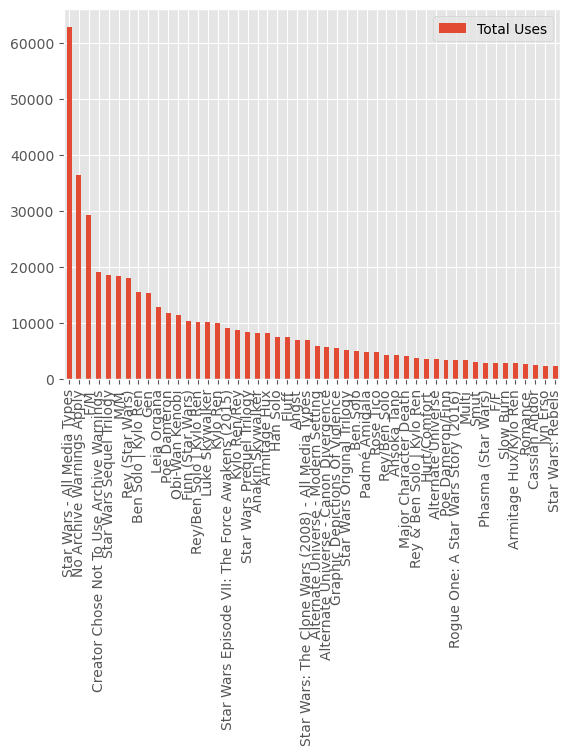

    tagId  Total Uses                                   Tag Name      Tag Type
0    3224       54151                                     Naruto        fandom
1       1       27910                  No Archive Warnings Apply       warning
2      17       25569                                        M/M      category
3    7150       20393                             Uzumaki Naruto     character
4       9       18214  Creator Chose Not To Use Archive Warnings       warning
5   10823       18146                              Uchiha Sasuke     character
6      44       17619                                        F/M      category
7    3599       17243                             Hatake Kakashi     character
8    7151       14746                              Haruno Sakura     character
9      38       12295                                        Gen      category
10  14360        7361                              Uchiha Itachi     character
11  14358        6763               Uchiha Sasuke/Uz

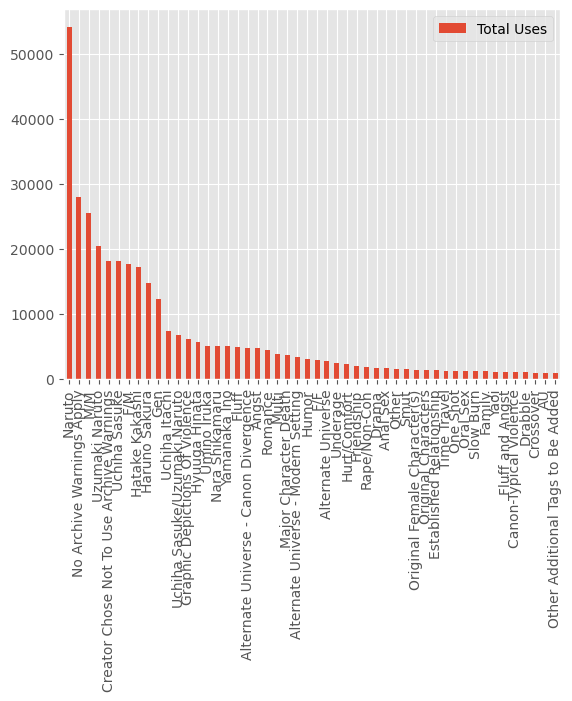

    tagId  Total Uses                                   Tag Name      Tag Type
0   28781       53720                       One Direction (Band)        fandom
1      17       47586                                        M/M      category
2   28782       41636                               Harry Styles     character
3   22111       39266                            Louis Tomlinson     character
4   29837       29995               Harry Styles/Louis Tomlinson  relationship
5   29481       28131                                Niall Horan     character
6       9       28106  Creator Chose Not To Use Archive Warnings       warning
7   22110       27582                                 Liam Payne     character
8   29480       26586                                 Zayn Malik     character
9       1       23417                  No Archive Warnings Apply       warning
10    121       11387                                      Fluff       generic
11  33728        8180                      Zayn Mali

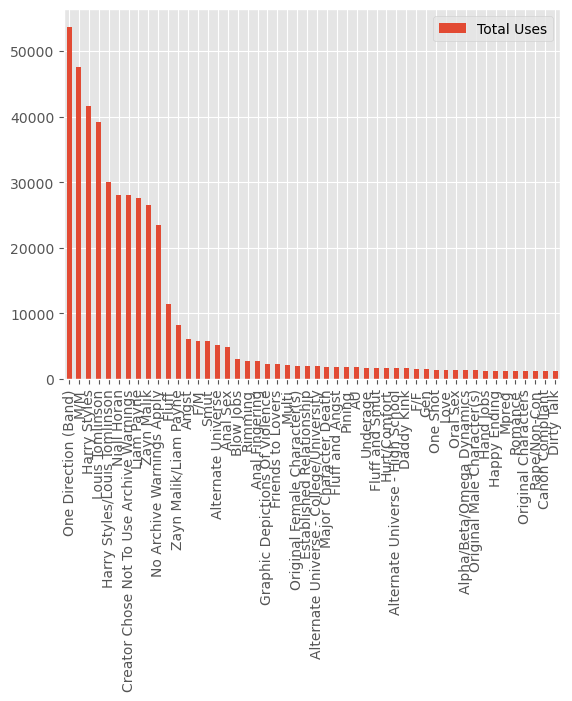

    tagId  Total Uses                                   Tag Name      Tag Type
0    9042       52335                                  Homestuck        fandom
1       1       25447                  No Archive Warnings Apply       warning
2      17       24026                                        M/M      category
3    9045       19616                               Dave Strider     character
4       9       19387  Creator Chose Not To Use Archive Warnings       warning
5   10426       16448                              Karkat Vantas     character
6    9043       13078                                John Egbert     character
7      44       12104                                        F/M      category
8    9044       11498                               Rose Lalonde     character
9      38        9901                                        Gen      category
10    105        8872                                        F/F      category
11  24779        8438                               

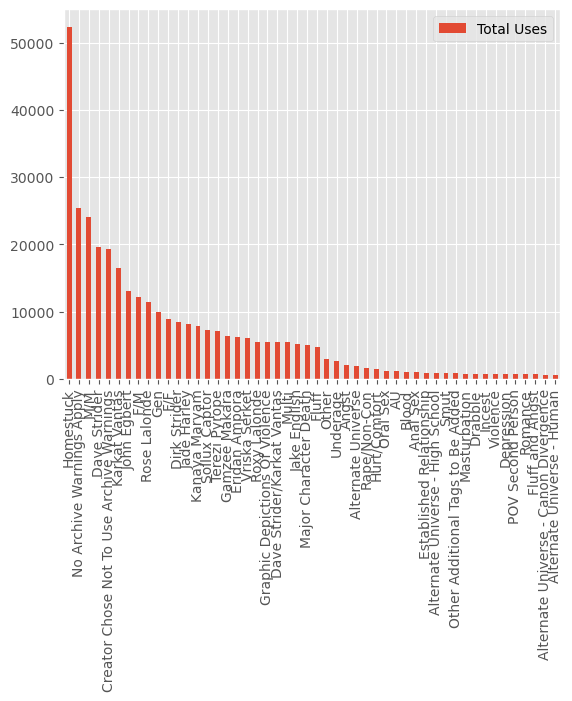

     tagId  Total Uses                                   Tag Name  \
0    28417       46780    The Avengers (Marvel) - All Media Types   
1     1461       28604                                 Tony Stark   
2     1462       26931                               Steve Rogers   
3        1       25066                  No Archive Warnings Apply   
4    26269       24288               The Avengers (Marvel Movies)   
5       17       23328                                        M/M   
6     8020       23248                  Marvel Cinematic Universe   
7    10291       18128                               Clint Barton   
8        9       17713  Creator Chose Not To Use Archive Warnings   
9    19379       15864                       James "Bucky" Barnes   
10      44       15100                                        F/M   
11   22537       11642                               Bruce Banner   
12   38528       10033                   Natasha Romanov (Marvel)   
13      38        9698            

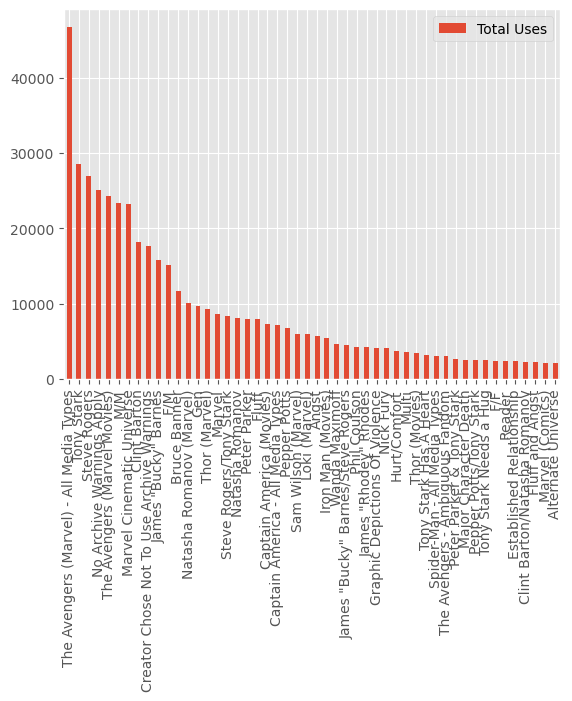

    tagId  Total Uses                                   Tag Name      Tag Type
0   24937       43836                      Once Upon a Time (TV)        fandom
1   23172       25278                                  Emma Swan     character
2       1       24581                  No Archive Warnings Apply       warning
3      44       23241                                        F/M      category
4   28041       19759                  Evil Queen | Regina Mills     character
5       9       17162  Creator Chose Not To Use Archive Warnings       warning
6     105       15227                                        F/F      category
7   41019       12848               Captain Hook | Killian Jones     character
8   34237       11665        Evil Queen | Regina Mills/Emma Swan  relationship
9   44899       10069     Captain Hook | Killian Jones/Emma Swan  relationship
10  26354        9563       Snow White | Mary Margaret Blanchard     character
11  43288        9514             Henry Mills (Once 

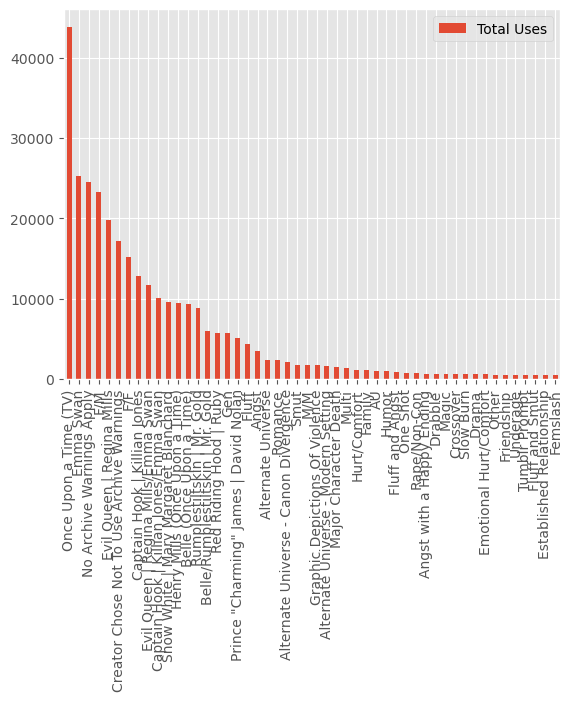

    tagId  Total Uses                                      Tag Name  \
0    4889       42344                          Game of Thrones (TV)   
1      44       30704                                           F/M   
2    9500       28547  A Song of Ice and Fire - George R. R. Martin   
3   16250       20064                                   Sansa Stark   
4       9       18870     Creator Chose Not To Use Archive Warnings   
5   16249       17291                                      Jon Snow   
6       1       17038                     No Archive Warnings Apply   
7    6684       12021                                    Arya Stark   
8   28200       10545      A Song of Ice and Fire & Related Fandoms   
9    4900        9842                               Jaime Lannister   
10   7456        8402                            Daenerys Targaryen   
11   1757        8248           Alternate Universe - Modern Setting   
12  16676        7956                              Brienne of Tarth   
13  16

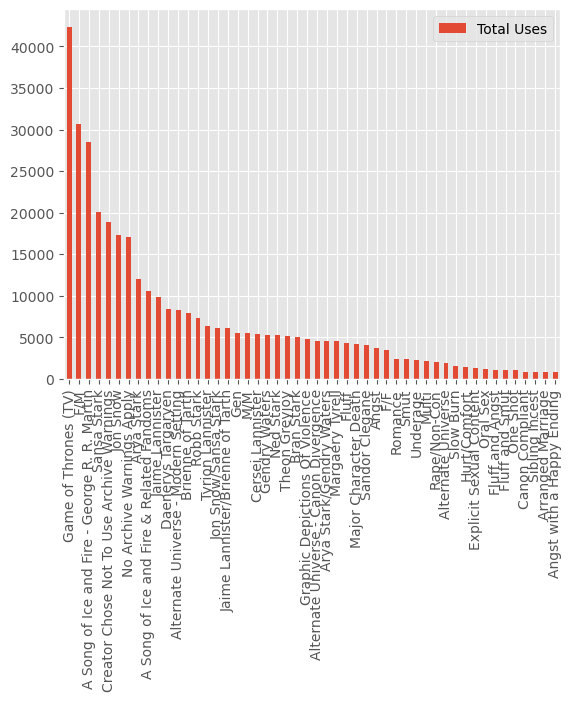

    tagId  Total Uses                                   Tag Name      Tag Type
0   57096       42206       Shingeki no Kyojin | Attack on Titan        fandom
1      17       28420                                        M/M      category
2   58470       23857                  Levi (Shingeki no Kyojin)     character
3   62133       22646                                Eren Yeager     character
4       1       18103                  No Archive Warnings Apply       warning
5       9       17797  Creator Chose Not To Use Archive Warnings       warning
6   57097       13898                              Jean Kirstein     character
7   63435       13708                                Erwin Smith     character
8   60456       13687                               Armin Arlert     character
9   63178       13315                           Levi/Eren Yeager  relationship
10  59663       12915                            Mikasa Ackerman     character
11     44       10100                               

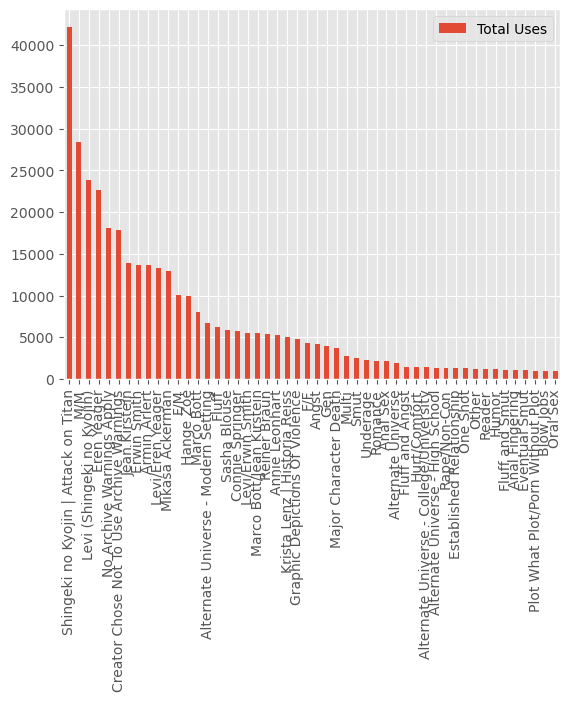

In [8]:
# Now we go through the same sorting as earlier:
def sort_tags(df):
    tag_count = df["tagId"].value_counts().to_frame("Total Uses").reset_index()
    for iden in tag_count["tagId"]:
        tags = tag_count[tag_count["tagId"] == iden].reset_index()
        #print(tags)
        off_ind = tags.loc[0, "index"]
        
        tag_ind = df[df["tagId"] == iden].reset_index()
        tag_name = tag_ind.loc[0, "name"]
        tag_type = tag_ind.loc[0, "type"]
        
        tag_count.loc[off_ind, "Tag Name"] = tag_name
        tag_count.loc[off_ind, "Tag Type"] = tag_type
       
    return tag_count 
        

# In order to look at the most popular tags in each fandom, we need 
# find only works for each of the fandoms. This requires us to go back to top_tags

# for tag in fan_10["tagId"].tolist():
for tag in fan_10["tagId"].tolist():
    
    story_fan = top_tags[top_tags["tagId"] == tag]
    story_fan = story_fan["storyId"].tolist() 
# Help with isin: https://www.geeksforgeeks.org/python-pandas-dataframe-isin/
    fan_assess = top_tags["storyId"].isin(story_fan)
    fan_all = top_tags[fan_assess]
    fan_all = sort_tags(fan_all)
    
    top_fan = fan_all[:50]
    print(top_fan)
    
    plot_name(top_fan)

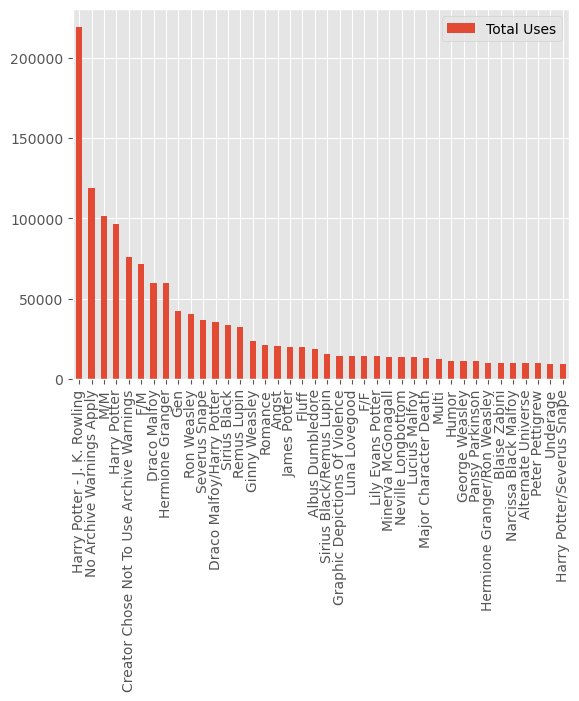

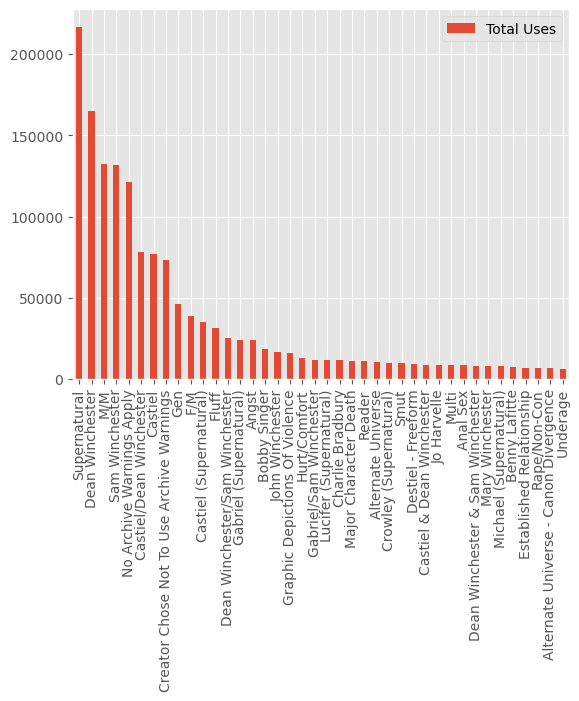

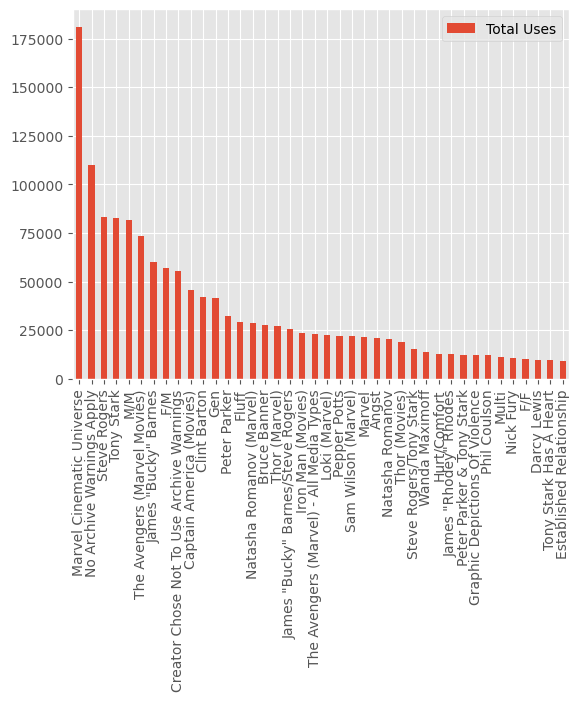

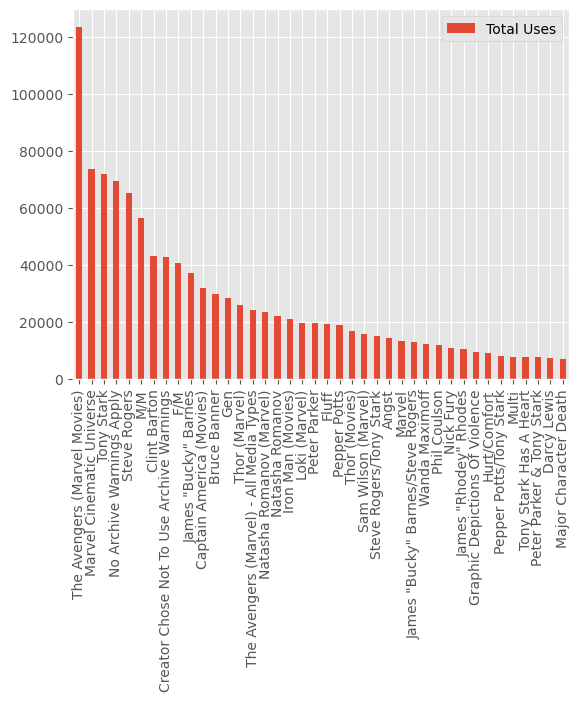

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 48169 (\N{HANGUL SYLLABLE BANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 53444 (\N{HANGUL SYLLABLE TAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 49548 (\N{HANGUL SYLLABLE SO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45380 (\N{HANGUL SYLLABLE NYEON}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from curr

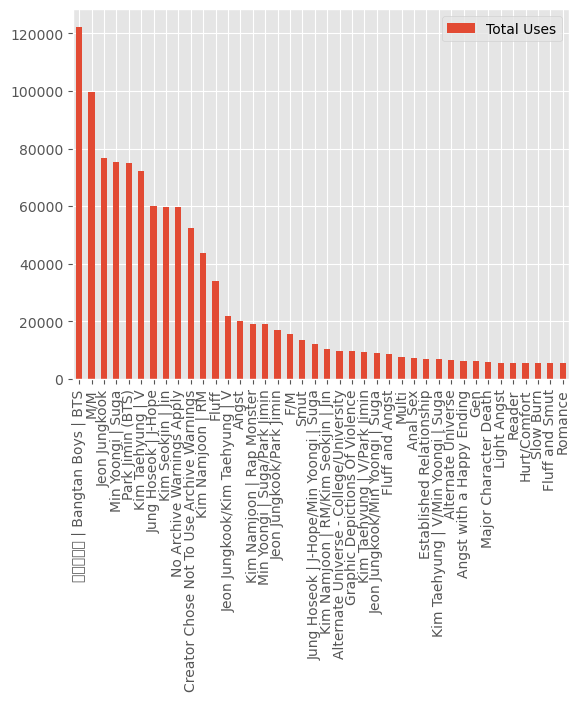

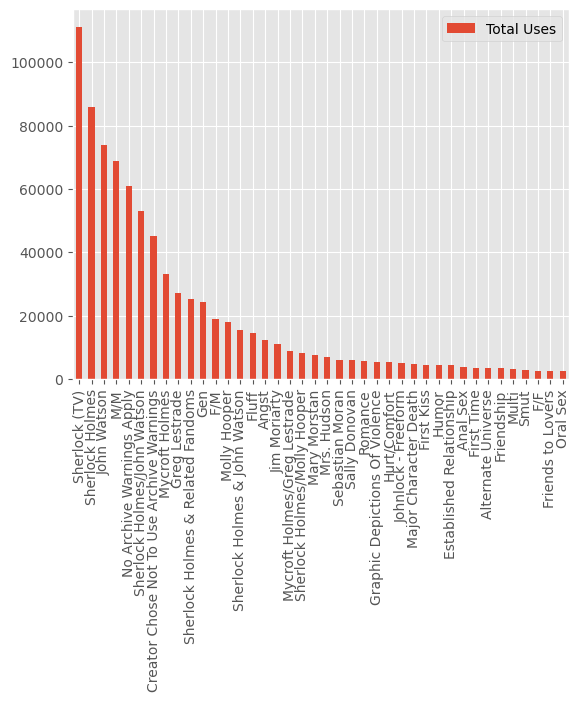

/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20693 (\N{CJK UNIFIED IDEOGRAPH-50D5}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12398 (\N{HIRAGANA LETTER NO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12498 (\N{KATAKANA LETTER HI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12540 (\N{KATAKANA-HIRAGANA PROLONGED SOUND MARK}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/bekwashburn/anaconda3/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 12525 (\N{KATAKANA LETTER R

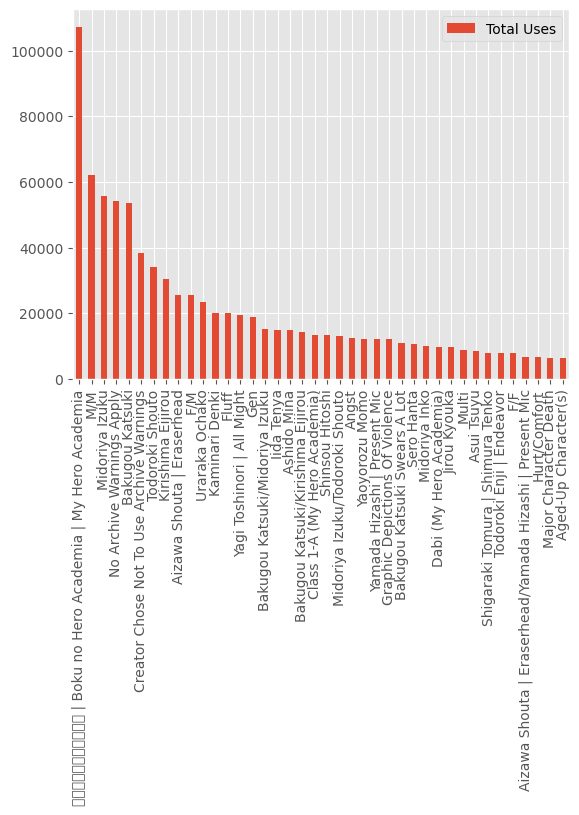

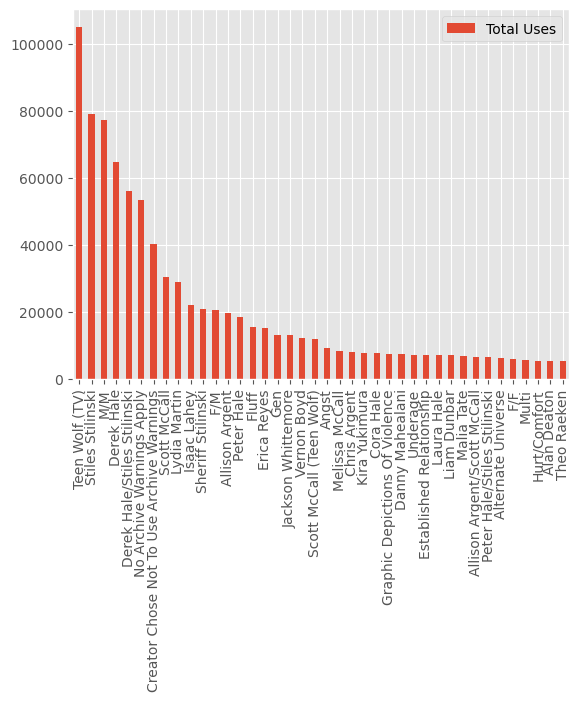

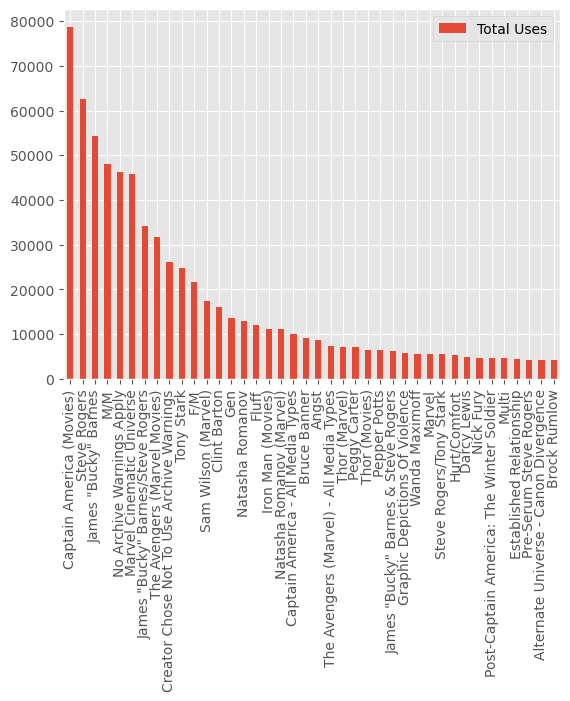

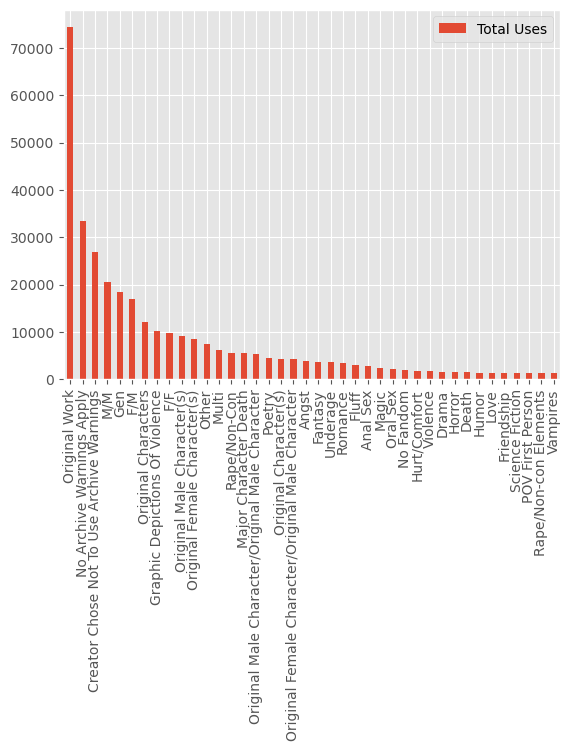

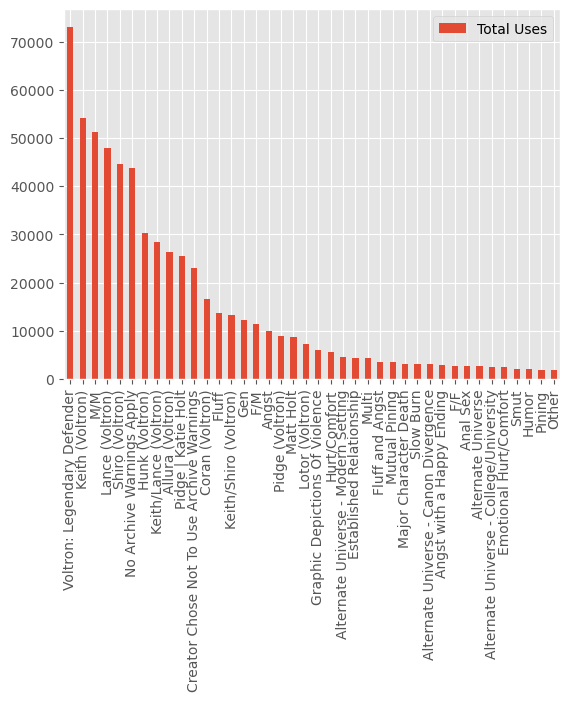

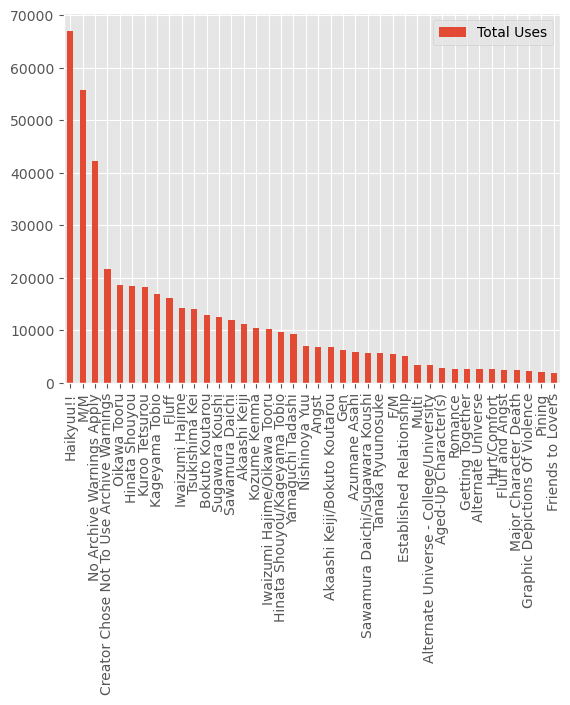

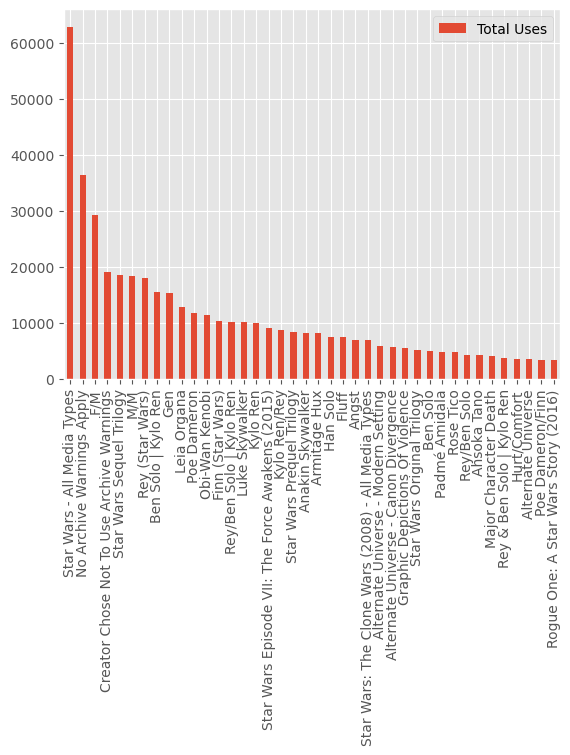

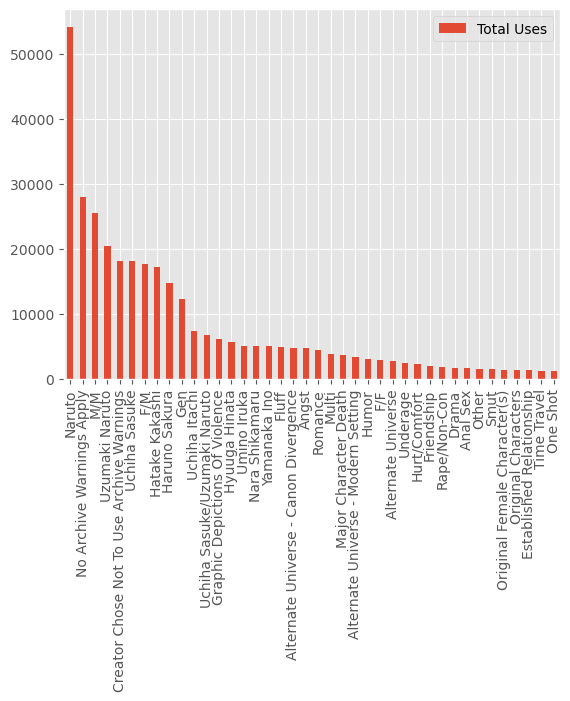

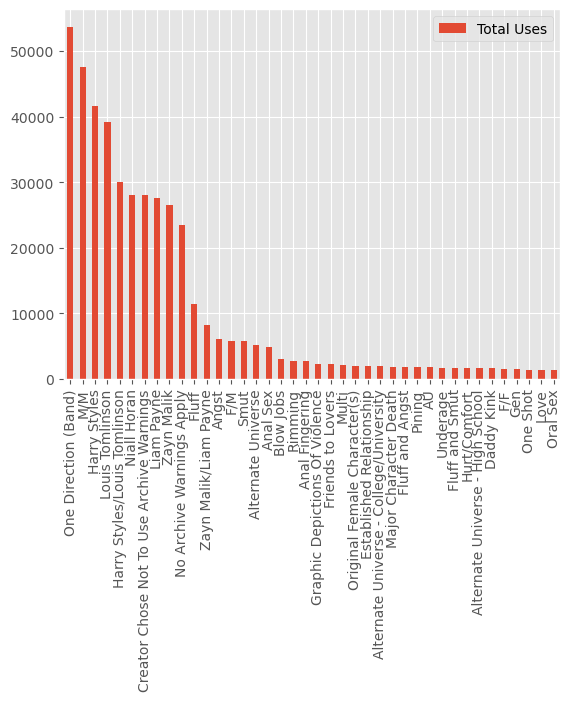

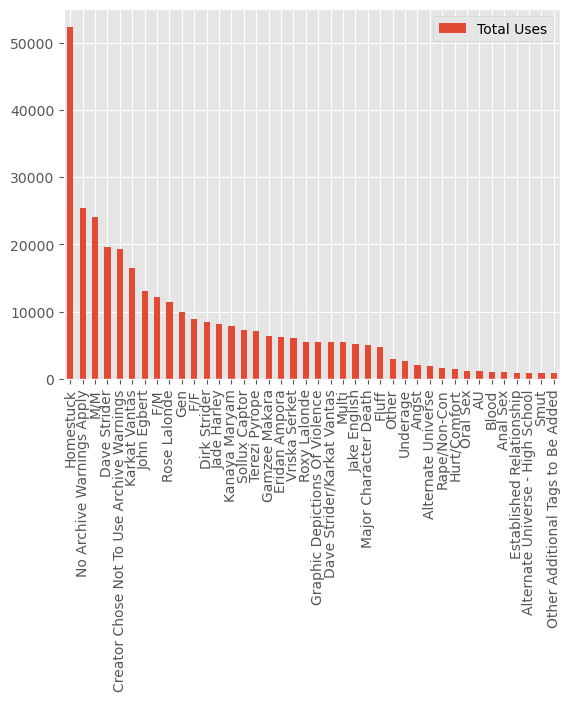

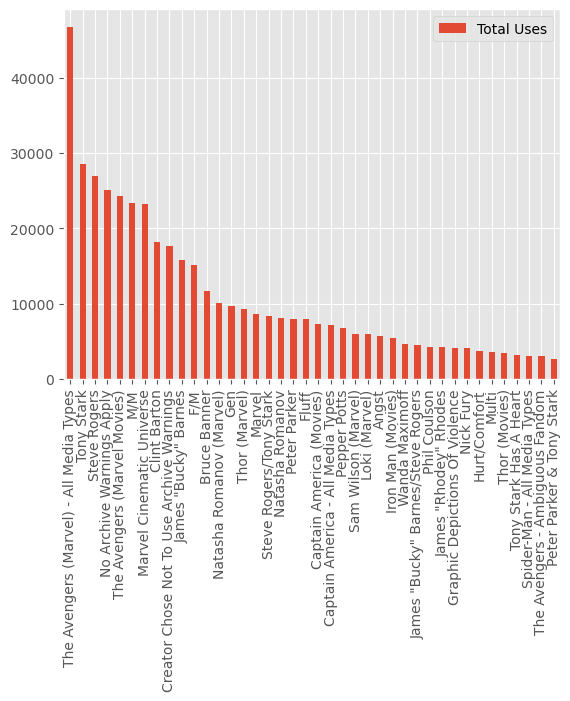

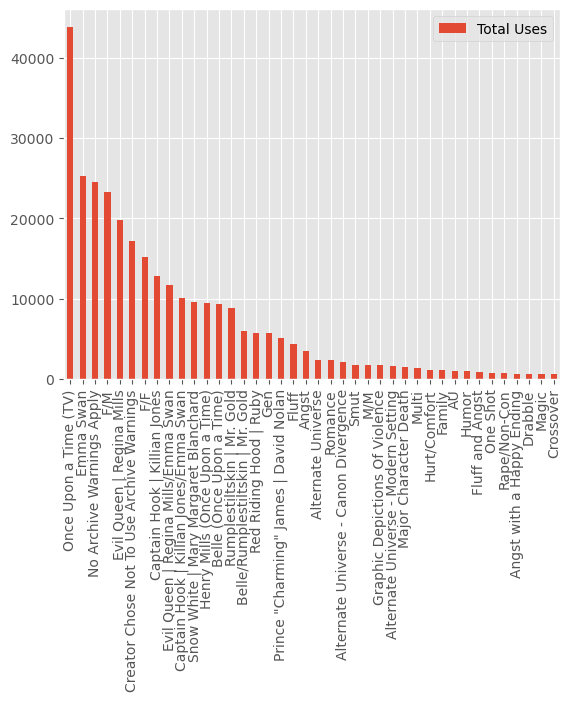

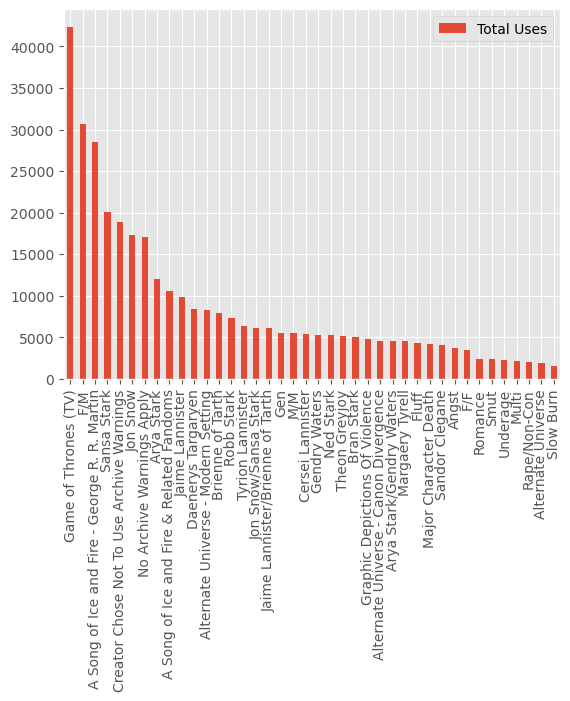

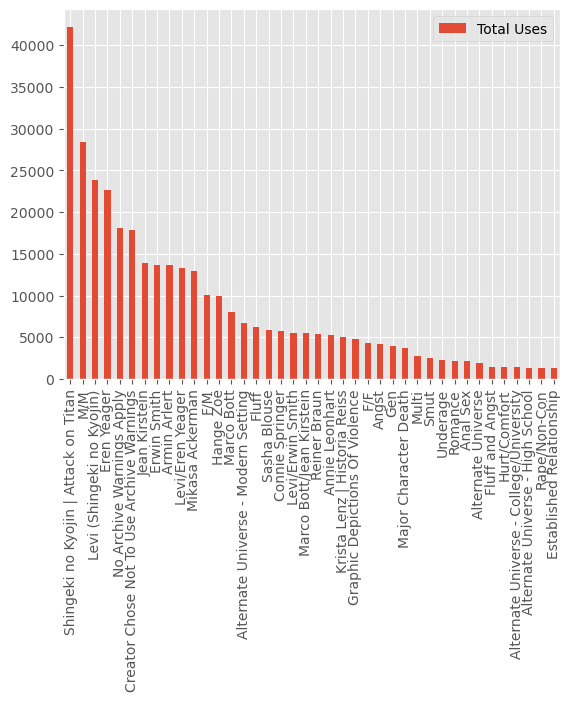

In [9]:
# this function was going to be used, but I decided against it

def remove_char_rel(df):
    new_df = df.copy(deep= True)
    new_df = new_df[new_df["Tag Type"] != "relationship"]
    new_df = new_df[new_df["Tag Type"] != "character"]
    new_df = new_df[new_df["Tag Type"] != "fandom"]
    new_df = new_df.reset_index()
    return new_df


fan_tags_list = []
    
for tag in fan_10["tagId"].tolist():
    
    story_fan = top_tags[top_tags["tagId"] == tag]
    story_fan = story_fan["storyId"].tolist() 
# Help with isin: https://www.geeksforgeeks.org/python-pandas-dataframe-isin/
    fan_assess = top_tags["storyId"].isin(story_fan)
    fan_all = top_tags[fan_assess]
    fan_all = sort_tags(fan_all)
    #no_ships = remove_char_rel(fan_all)
    no_ships = fan_all[:40]
    fan_tags_list.append(no_ships)
    plot_name(no_ships)

We want to see what tags the fandoms have in common.

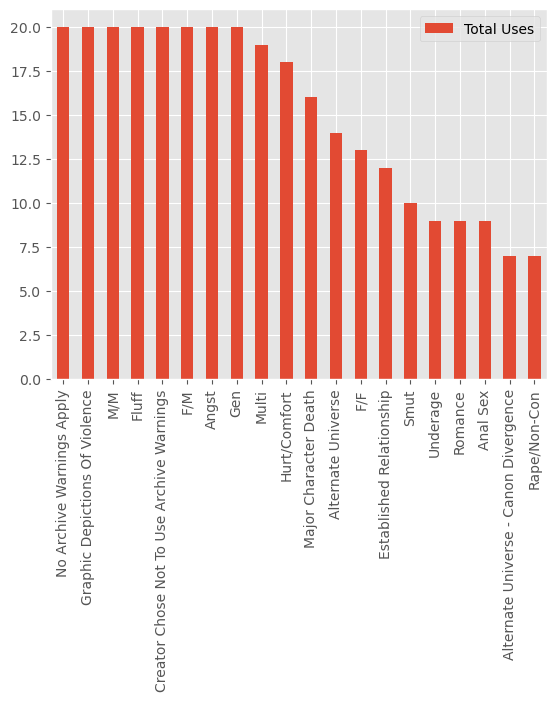

index  tagId  Total Uses                                   Tag Name  \
0       1      1          20                  No Archive Warnings Apply   
1      21    413          20             Graphic Depictions Of Violence   
2       2     17          20                                        M/M   
3      18    121          20                                      Fluff   
4       4      9          20  Creator Chose Not To Use Archive Warnings   
5       5     44          20                                        F/M   
6      16     15          20                                      Angst   
7       8     38          20                                        Gen   
8      29    213          19                                      Multi   
9      50    621          18                               Hurt/Comfort   
10     28     31          16                      Major Character Death   
11     36    103          14                         Alternate Universe   
12     23    105          13                                        F/F   
13     65    286          12                   Established Relationship   
14     56    509          10                                       Smut   
15     38    298           9                                   Underage   
16     15    287           9                                    Romance   
17     60   2533           9                                   Anal Sex   
18     67    144           7      Alternate Universe - Canon Divergence   
19     66    204           7                               Rape/Non-Con   

    Tag Type  
0    warning  
1    warning  
2   category  
3    generic  
4    warning  
5   category  
6    generic  
7   category  
8   category  
9    generic  
10   warning  
11   generic  
12  category  
13   generic  
14   generic  
15   warning  
16   generic  
17   generic  
18   generic  
19   warning

In [10]:
pop_tags = { }

for fandom in fan_tags_list:
    for tag in fandom["tagId"]:
        if tag in pop_tags:
            pop_tags[tag] += 1
        else:
            pop_tags[tag] = 1


pop_tags_df = pd.DataFrame({
    "tagId": pop_tags.keys(),
    "Total Uses": pop_tags.values()
})

for iden in pop_tags_df["tagId"]:
    tags = pop_tags_df[pop_tags_df["tagId"] == iden].reset_index()
    off_ind = tags.loc[0, "index"]
    
    tag_ind = top_tags[top_tags["tagId"] == iden].reset_index()
    tag_name = tag_ind.loc[0, "name"]
    tag_type = tag_ind.loc[0, "type"]
   
    pop_tags_df.loc[off_ind, "Tag Name"] = tag_name
    pop_tags_df.loc[off_ind, "Tag Type"] = tag_type

pop_tags_df = pop_tags_df.sort_values("Total Uses", ascending=False).reset_index()
pop_tags_df

top_30 = pop_tags_df.iloc[:20]

plot_name(top_30)
top_30

We now switch our analysis to tags that the most popular works have in common.

In [11]:
num_data = pd.read_csv("not_reduced_project_info.csv")
num_data = num_data.sort_values("kudos", ascending = False).reset_index()
top_num_data = num_data.iloc[:10000]
top_stories = top_num_data["id"].tolist()
top_stories
#for story in top_stories:
all_tags = pd.read_csv("tag_data.csv")

pop_story_tags1 = all_tags[all_tags["storyId"].isin(top_stories)]

pop_story_tags = pop_story_tags1["tagId"].value_counts().to_frame("Total Uses").reset_index()

top_pop_tags = pop_story_tags.iloc[:500]


for iden in top_pop_tags["tagId"]:

    tags = top_pop_tags[top_pop_tags["tagId"] == iden].reset_index()
    off_ind = tags.loc[0, "index"]
    tag_ind = pop_story_tags1.copy(deep=True)
    tag_ind = tag_ind[tag_ind["tagId"] == iden].reset_index()
    tag_name = tag_ind.loc[0, "name"]
   
    top_pop_tags.loc[off_ind, "Tag Name"] = tag_name

top_pop_tags                                          

/var/folders/dd/z5d_8l8j69xck23xsyrq_4rh0000gn/T/ipykernel_27339/4224914515.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_pop_tags.loc[off_ind, "Tag Name"] = tag_name


tagId  Total Uses                                           Tag Name
0        17        7711                                                M/M
1         1        5995                          No Archive Warnings Apply
2         9        3009          Creator Chose Not To Use Archive Warnings
3       121        1771                                              Fluff
4     20845        1526                                     Teen Wolf (TV)
..      ...         ...                                                ...
495   17574          62                      Erik Lehnsherr/Charles Xavier
496  280696          62  Aizawa Shouta | Eraserhead/Yamada Hizashi | Pr...
497    5075          62                                             Banter
498   31826          62                                      Touch-Starved
499   38564          62                                    Hurt Tony Stark

[500 rows x 3 columns]

In [12]:
# import os

# # This bit creates a csv of the Data Frame from the above code

# # DO NOT RUN! 

# try:
#     os.remove('pop_story_tags1.csv')
# except:
#     pass

# pop_story_tags1.to_csv('pop_story_tags1.csv')
# print('done')

In [13]:
# import os

# # This bit creates a csv of the Data Frame from the above code

# # DO NOT RUN! 

# try:
#     os.remove('all_pop_tags.csv')
# except:
#     pass

# top_pop_tags.to_csv('all_pop_tags.csv')
# print('done')

   Unnamed: 0  tagId  Total Uses                                   Tag Name
0           0     17        7711                                        M/M
1           1      1        5995                  No Archive Warnings Apply
2           2      9        3009  Creator Chose Not To Use Archive Warnings
3           3    121        1771                                      Fluff
4           4  20845        1526                             Teen Wolf (TV)
5           5     38        1488                                        Gen
6           6  20952        1378                Derek Hale/Stiles Stilinski
7           7   1461        1376                                 Tony Stark
8           8   1462        1369                               Steve Rogers
9           9  20991        1333                           Stiles Stilinski


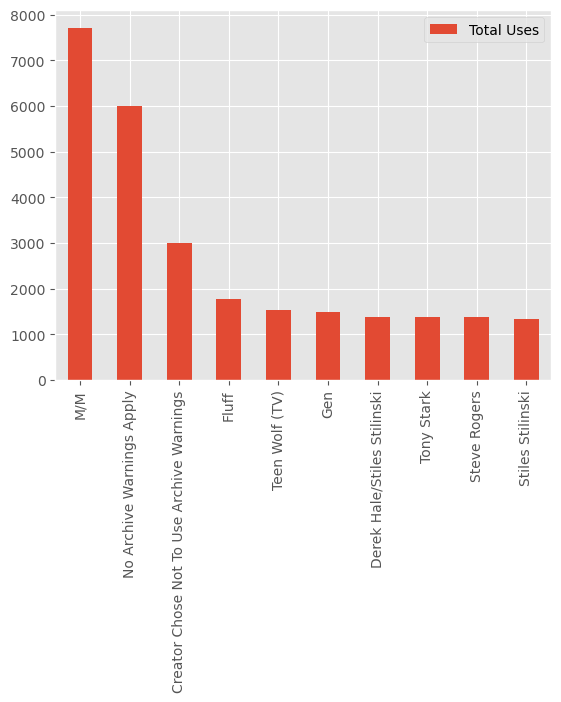

        index  Unnamed: 0        id                               title  \
0     1120845     1120845   2080878                          I Am Groot   
1     2413486     2413486   8337607            Yesterday Upon The Stair   
2     1836371     1836371   5457191                         a reylo fic   
3     2302621     2302621   7841764                    call me, beep me   
4      422097      422097    522776       Lock All The Doors Behind You   
...       ...         ...       ...                                 ...   
9995  2173033     2173033   7208117              just to know your name   
9996   642748      642748    812489  You Come Beating Like Moth's Wings   
9997  1462097     1462097   3753061                RED's In This Season   
9998  3992431     3992431  16104377                  Wish Upon The Moon   
9999  2608231     2608231   9431732                I Wish You Were Mine   

            date  language Language_Name  restricted  rating  finished  \
0     2014-08-04       1.

In [ ]:
top_pop_tags = pd.read_csv("all_pop_tags.csv")
pop_story_tags1 = pd.read_csv("pop_story_tags1.csv")
top_top_30 = top_pop_tags[:10]
print(top_top_30)
plot_name(top_top_30)

# sort so we only have these top tags.

top_tier_tags = top_top_30["tagId"].tolist()

#top_pop_tags
get_story_id = pop_story_tags1[pop_story_tags1["tagId"].isin(top_tier_tags)].reset_index()

top_num_data = top_num_data[top_num_data["id"].isin(get_story_id["storyId"]).tolist()]
print(top_num_data)
get_story_id
num_data_copy = top_num_data.copy(deep=True)
num_data_copy = num_data_copy[["id", "kudos"]]
print(num_data_copy)
lists = ["tag17", "tag1", "tag9", "tag121", "tag20845", "tag38", "tag20952", "tag1461", "tag1462", "tag20991"]
count = 0

for tags in top_tier_tags:
    print(tags)
    col = lists[count]
    print(col)
    only_tags = get_story_id[get_story_id["tagId"] == tags]
    print(only_tags)
    count += 1
    for story in num_data_copy["id"]:
        new_data = num_data_copy.copy(deep=True)
        if story in only_tags["storyId"].tolist():
            index = new_data[new_data["id"] == story].index.tolist()[0]
            num_data_copy.loc[index, col] = 1
        else:
            index = new_data[new_data["id"]== story].index.tolist()[0]
            num_data_copy.loc[index, col] = 0
print(only_tags["storyId"])
        

num_data_copy
#for story in get_story_id["storyId"].tolist():
    
    #only_story = get_story_id[get_story_id["storyID"] == story]

In [ ]:
# import os

# # This bit creates a csv of the Data Frame from the above code

# # DO NOT RUN! 

# try:
#     os.remove('corr_kudos.csv')
# except:
#     pass

# num_data_copy.to_csv('corr_kudos.csv')
# print('done')

### % Of Restricted Works

To find the % of works that are restricted by their authors and thus not in our sample, we will go through the whole list of works and count the number of restricted ones.

In [11]:
# Load the data from the CSV file
data = pd.read_csv("not_reduced_project_info.csv")

# Calculate the percentage of restricted works
restricted_percentage = (data['restricted'].sum() / len(data)) * 100

print("Percentage of restricted works:", round(restricted_percentage, 2), "%")

Percentage of restricted works: 4.4 %


### Result: Restriction is Uncommon

Less than 5% of works in our sample are restricted.